In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

# Testing version E

In [2]:
casestore = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    dict(name="D", id="xfla6-version_D", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),  
    dict(name="E", id="xfla7-version_E", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True), 

]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            unnormalise_geom = case["unnormalise_geom"])


In [4]:
for name in casestore:
    if name in ["E"]:
        casestore[name].ds = calculate_radial_fluxes(casestore[name].ds, new_afn = True)
    else:
        casestore[name].ds = calculate_radial_fluxes(casestore[name].ds, new_afn = False)
    
    casestore[name].ds = reverse_pfr_fluxes(casestore[name].ds)

## Version E) 

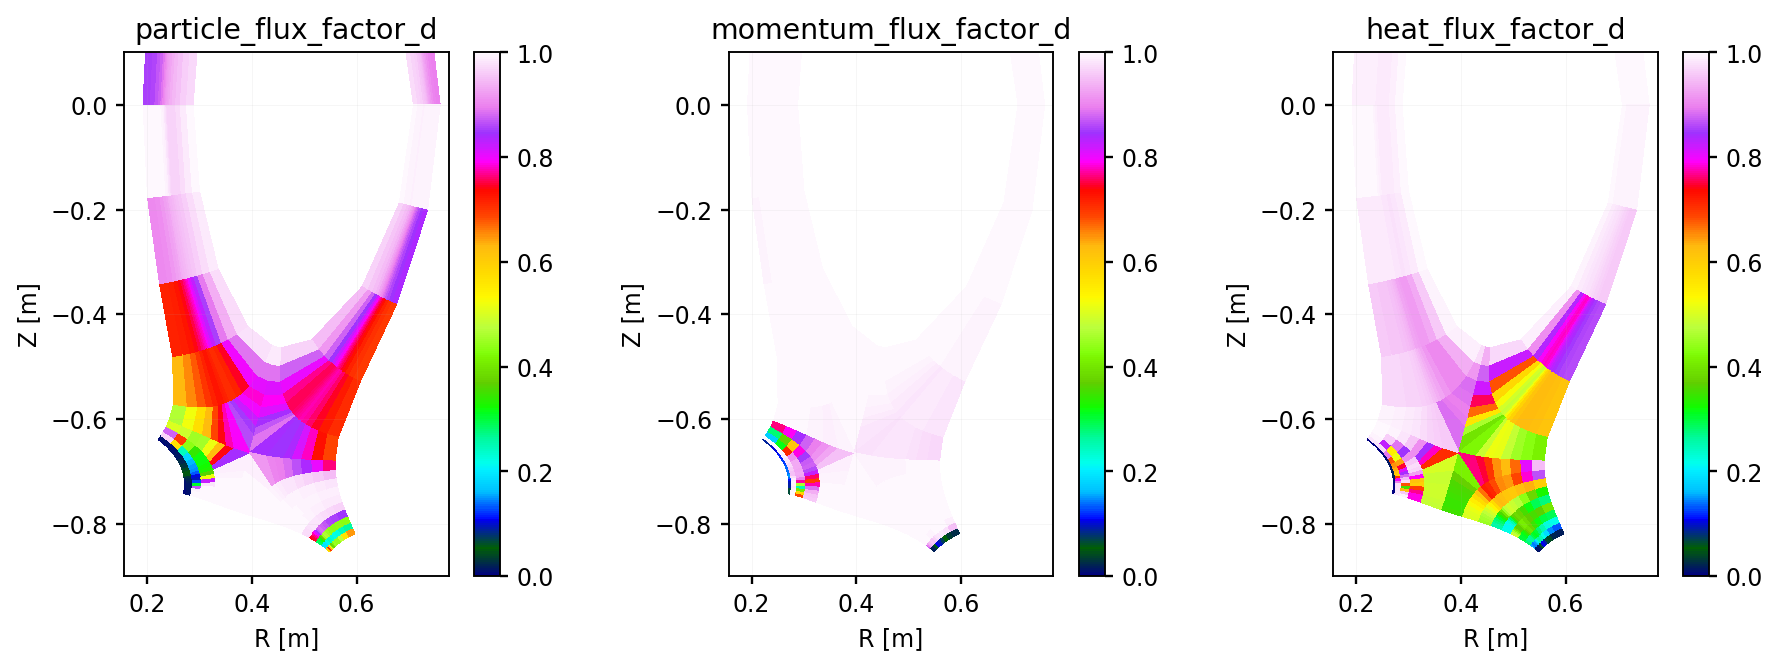

In [5]:
ds = casestore["E"].ds
if "t" in ds.dims.keys(): ds = ds.isel(t=-1)

fig, axes = plt.subplots(1,3, figsize=(13,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)
# ds["conductive_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[3], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

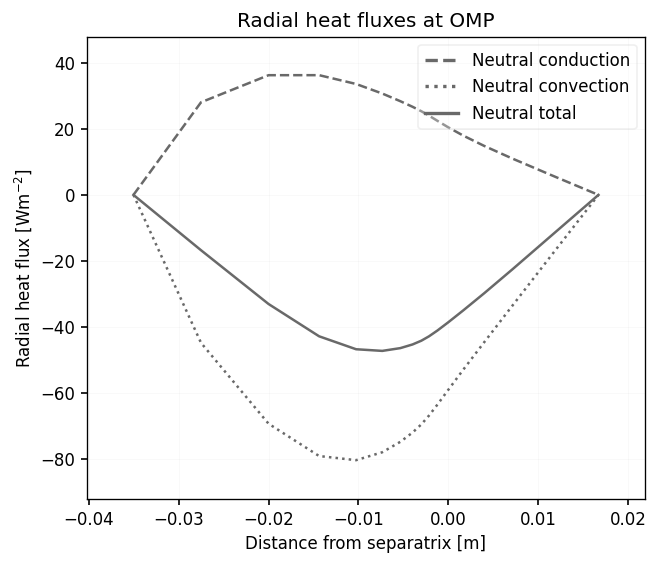

In [7]:
plot_perp_heat_fluxes(casestore["E"].ds, neutrals_only = True, loc = "omp")

Text(0.5, 1.0, 'Convection')

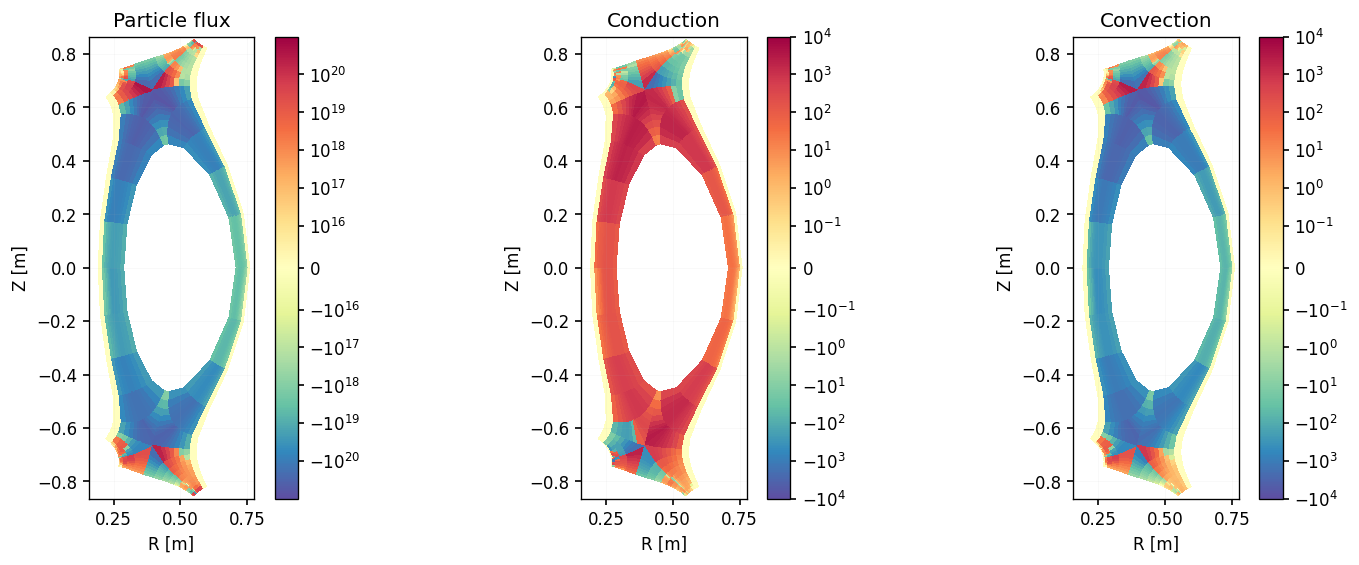

In [8]:
fig, axes = plt.subplots(1,3, figsize = (15,5), dpi = 120)

vmin = -1e5
vmax = 1e5
logscale = True

ds = casestore["E"].ds
if "t" in ds.dims.keys(): ds = ds.isel(t=-1)
dpol = ds["dy"] * 1/np.sqrt(ds["g_22"])
dtor = ds["dz"] * np.sqrt(ds["g_33"])
da_rad = dpol * dtor

lim = 1e21
(ds["pf_perp_diff_R_d"]/da_rad).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", vmin = -lim, vmax = lim, logscale = logscale)
axes[0].set_title("Particle flux")

lim = 1e4
(ds["hf_perp_diff_R_d"]/da_rad).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", vmin = -lim, vmax = lim, logscale = logscale)
axes[1].set_title("Conduction")

lim = 1e4
(ds["hf_perp_conv_R_d"]/da_rad).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", vmin = -lim, vmax = lim, logscale = logscale)
axes[2].set_title("Convection")


# for ax in axes:
#     ax.set_ylim(-0.9, 0.1)




## D) New AFN

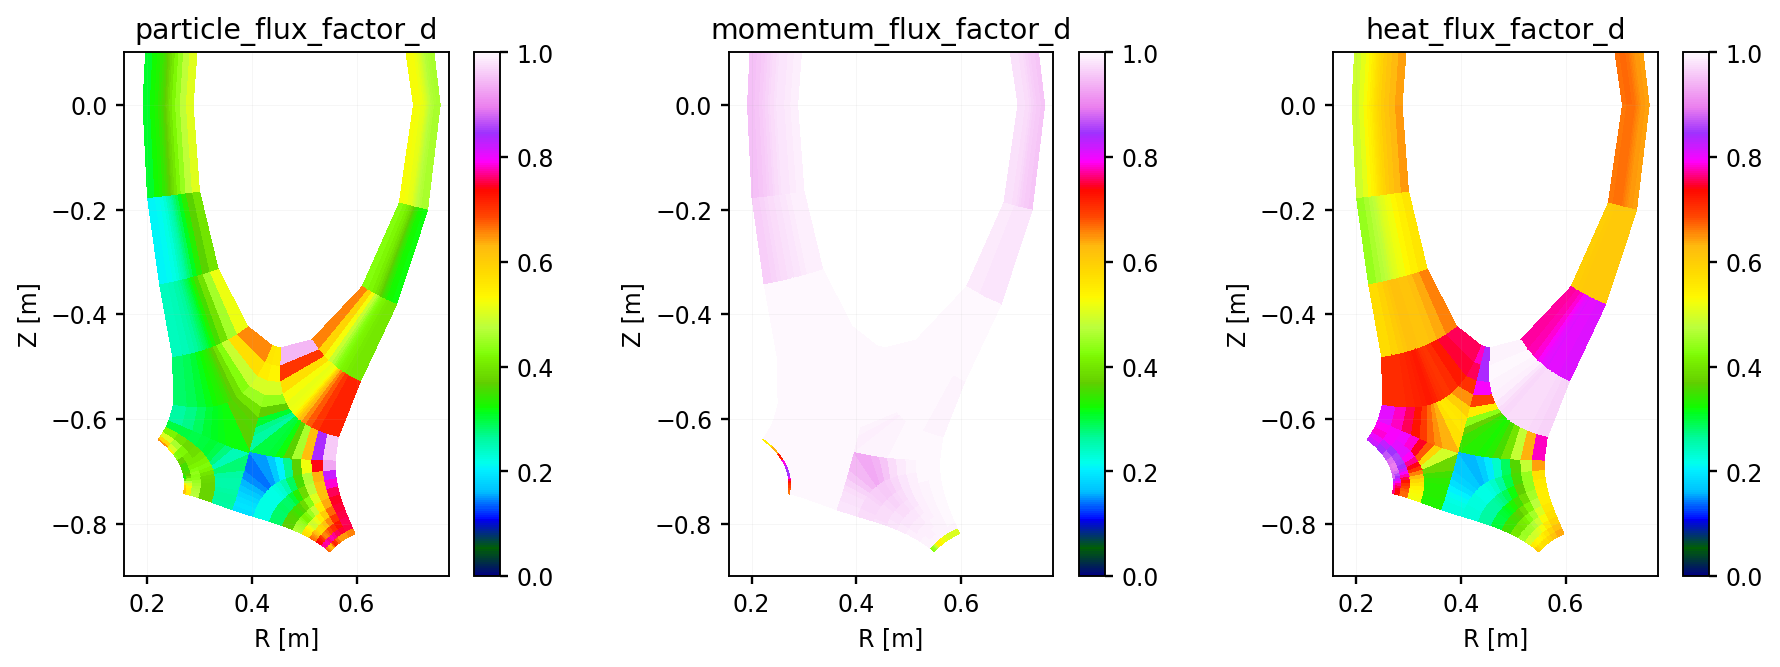

In [9]:
ds = casestore["D"].ds
if "t" in ds.dims.keys(): ds = ds.isel(t=-1)

fig, axes = plt.subplots(1,3, figsize=(13,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)
# ds["conductive_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[3], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

## Chained, separate limiters, limit conduction

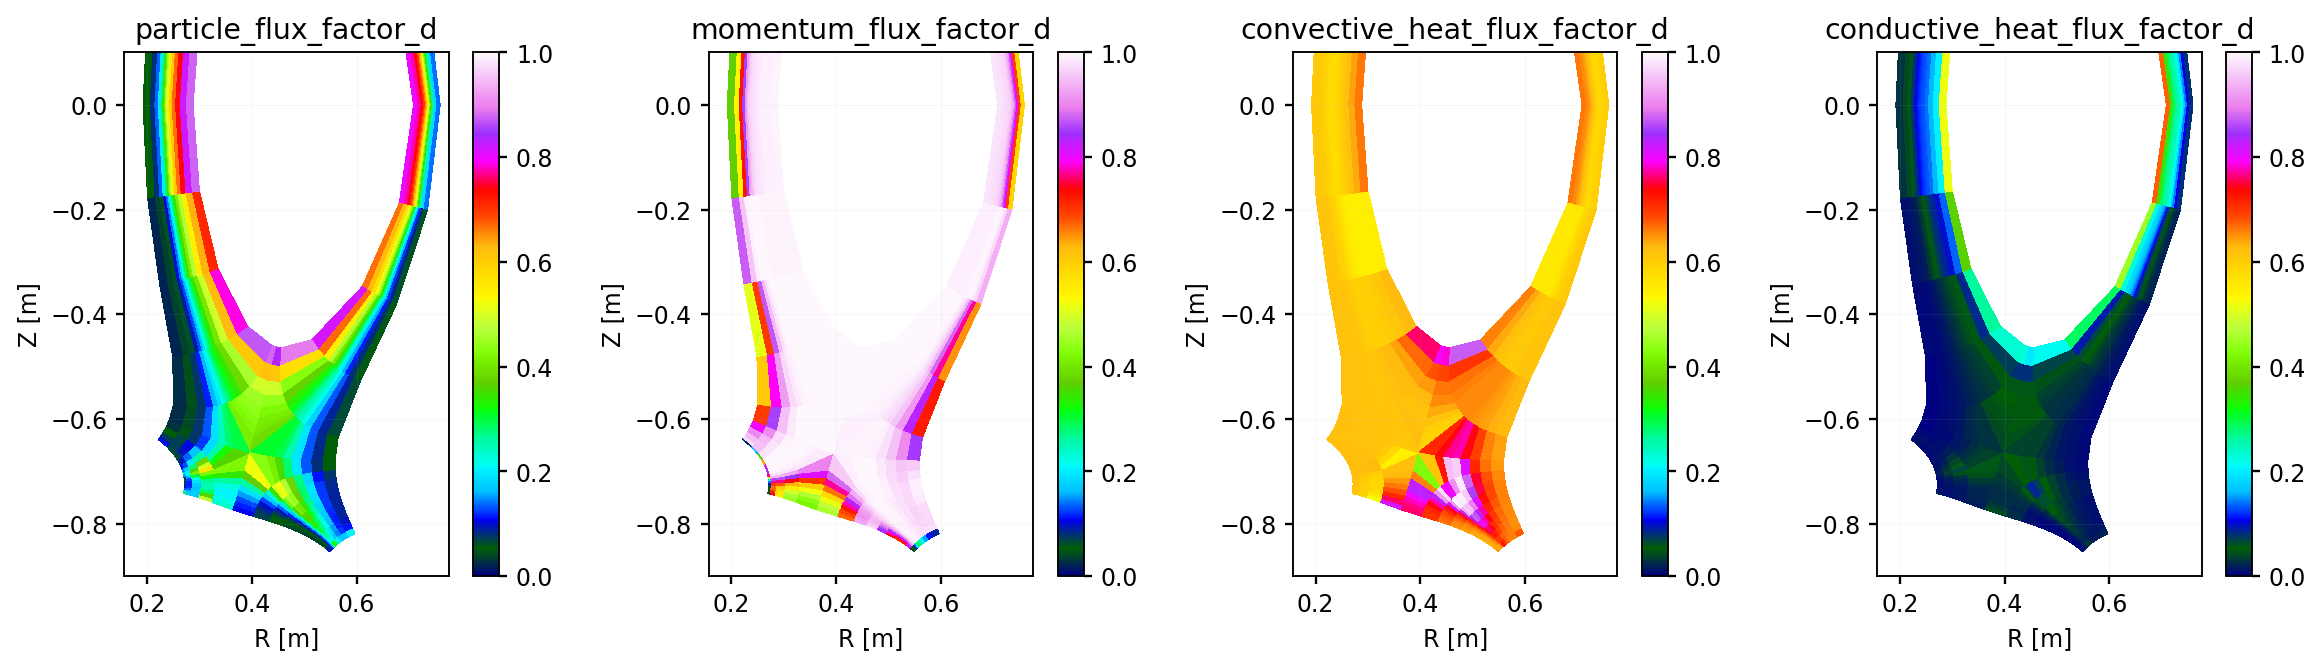

In [5]:
ds = casestore["limitcond"].ds
if "t" in ds.dims.keys(): ds = ds.isel(t=-1)

fig, axes = plt.subplots(1,4, figsize=(17,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["convective_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["conductive_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[3], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

## Chained, separate limiters, limit conduction and momentum

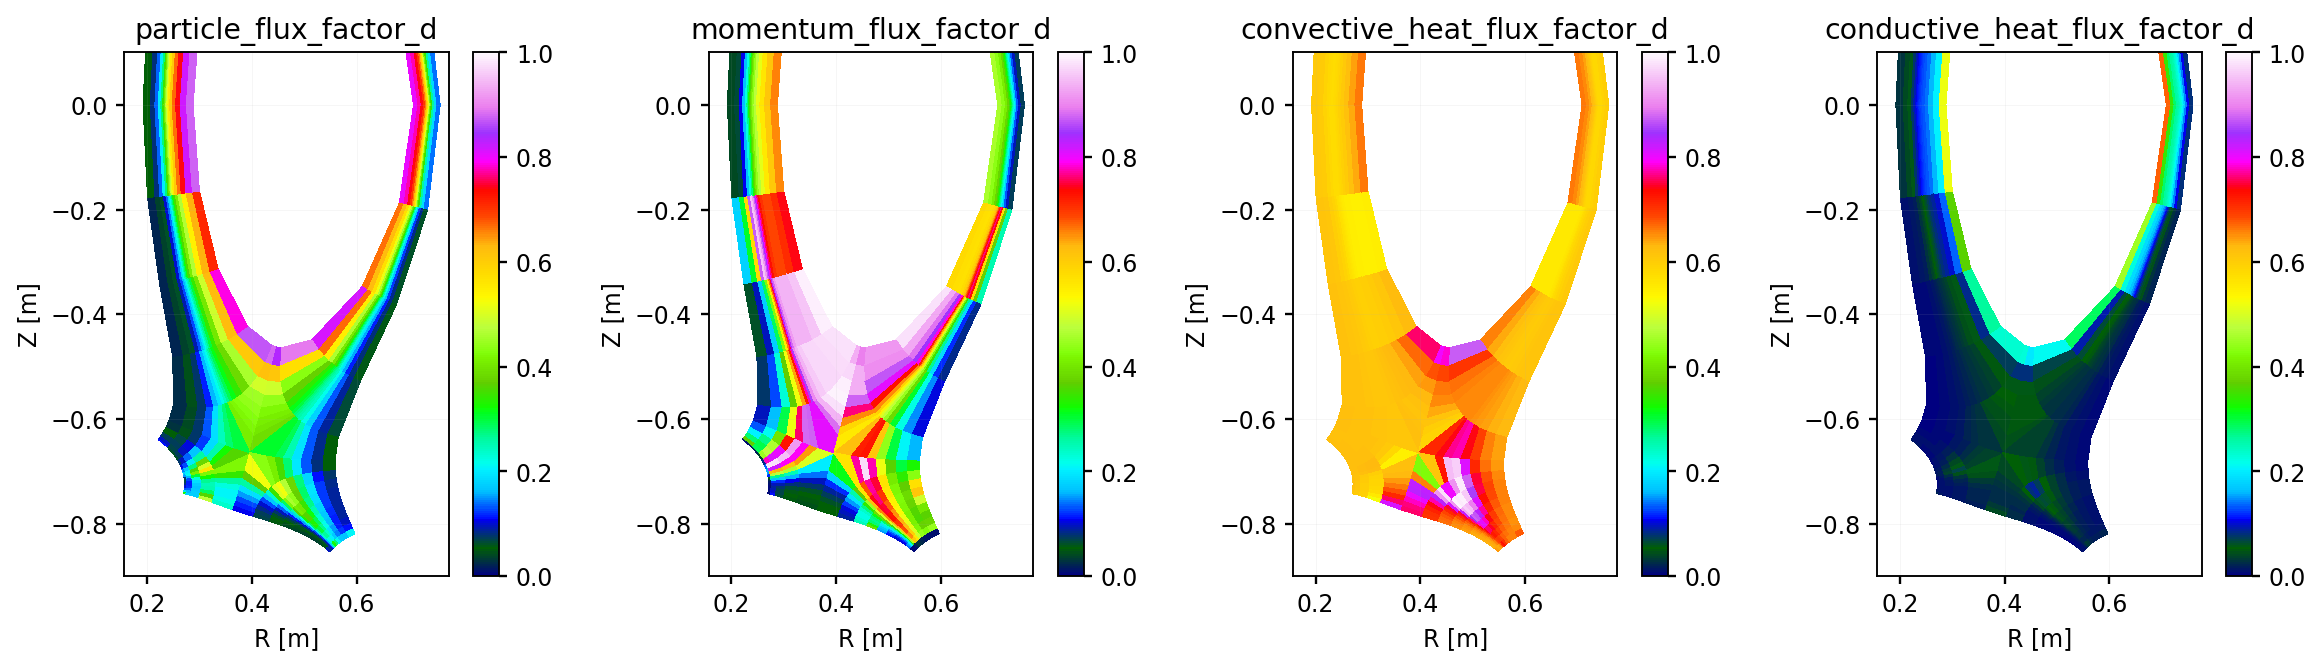

In [6]:
ds = casestore["limitmom"].ds
if "t" in ds.dims.keys(): ds = ds.isel(t=-1)

fig, axes = plt.subplots(1,4, figsize=(17,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["convective_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["conductive_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[3], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

In [ ]:
casestore["new"].ds.data_vars

In [9]:
casestore["B"].ds.dims

Frozen({'x': 20, 'theta': 58})

B
Integrating poloidally
E
Integrating poloidally


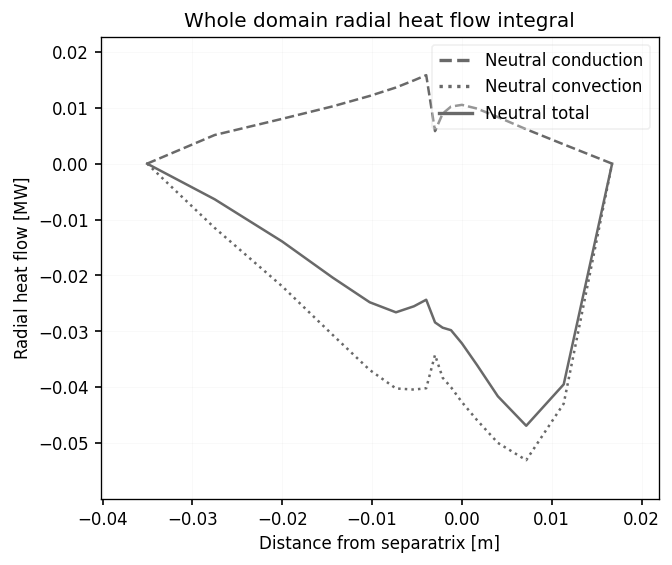

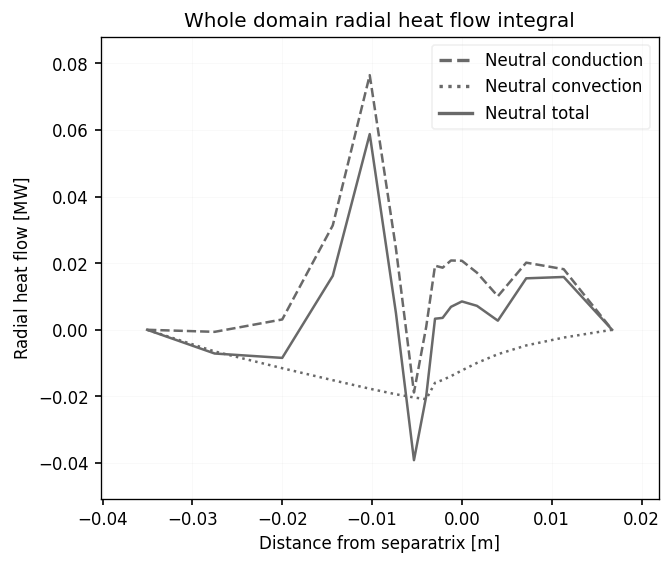

In [11]:
# ds = casestore["base"].ds
for name in casestore:
    print(name)
    ds = casestore[name].ds
    if "t" in ds.dims.keys(): ds = ds.isel(t=-1)
    plot_perp_heat_fluxes(ds, neutrals_only = True, loc = "integral")